In [5]:
import numpy as np
import matplotlib.pyplot as plt
from causalpy.bandits import BasicBernoulliModel
import seaborn as sns
%matplotlib inline

## Joint distribution over rewards
Does the joint distribution over rewards make any difference to the distribution over regret? (not to the expectation). 

In [164]:
# lets have assume 
from numpy.random import choice
k = 2
p = 0.5
q = 0.6
a = q-p

b = p-a
c = q-a
d = 1+a-p-q
print a,b,c,d

probs = np.asarray([a,b,c,d])

reward_vecs = np.asarray([[1,1],[1,0],[0,1],[0,0]])
v = np.arange(len(reward_vecs))

T = 200
simulations = 100000

plays = np.random.binomial(1,.5,size=T*simulations)
r = reward_vecs[choice(v,p=probs,size=T*simulations)]

player_reward = r[np.arange(len(plays)),plays].reshape(simulations,T).sum(axis=1)
arm1_reward = r[np.arange(len(plays)),np.zeros(len(plays),dtype=int)].reshape(simulations,T).sum(axis=1)
arm2_reward = r[np.arange(len(plays)),np.ones(len(plays),dtype=int)].reshape(simulations,T).sum(axis=1)


#print player_reward.mean(),player_reward.std()
print arm2_reward.mean(), arm2_reward.std()
print arm1_reward.mean(), arm1_reward.std()
d = arm2_reward - arm1_reward
print d.mean(),d.std()**2



0.1 0.4 0.5 1.11022302463e-16
120.04494 6.92481771575
99.95831 7.0480090766
20.08663 177.287505243


In [163]:
(p*(1-p)+q*(1-q)-2*(a-p*q))*T

178.0

In [131]:
optimal_reward = np.max(r.reshape(simulations,T,2).sum(axis=1),axis=1)


d = optimal_reward - player_reward
d2 = arm2_reward-player_reward

plt.hist(d)
print d.mean(),d.std()

print d2.mean(),d2.std()

86742

In [104]:
r.reshape(simulations,T,2).sum(axis=1)

array([[50, 48],
       [56, 48],
       [60, 51],
       [44, 50],
       [61, 53]])

In [105]:
np.max(r.reshape(simulations,T,2).sum(axis=1),axis=1)

array([50, 56, 60, 50, 61])

## Regret bounds

/home/finn/miniconda3/envs/latestp2/lib/python2.7/site-packages/ipykernel/__main__.py:4: RuntimeWarning: divide by zero encountered in divide
/home/finn/miniconda3/envs/latestp2/lib/python2.7/site-packages/ipykernel/__main__.py:15: RuntimeWarning: divide by zero encountered in divide


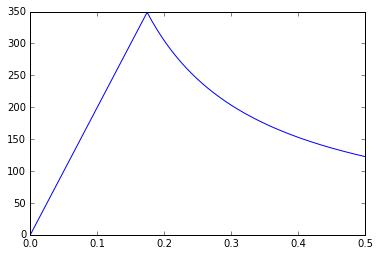

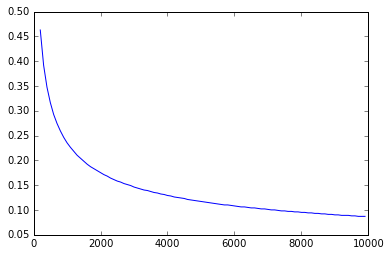

In [33]:
# 2 armed bandit, UCB-1
delta = np.linspace(0,.5,500)
T = 2000
a = 8*np.log(T)/delta + (1+np.pi/3)*delta
b = T*delta
r = np.minimum(a,b)

fig, ax = plt.subplots()
ax.plot(delta,r)

#plot the position of this spike as a function of delta
T_range = range(100,10000,100)
points = np.zeros(len(T_range))
for i,T in enumerate(T_range):
    a = 8*np.log(T)/delta + (1+np.pi/3)*delta
    b = T*delta
    cv = np.flatnonzero(a < b)
    if len(cv) == 0:
        points[i] = None
    else:
        points[i] = delta[cv[0]]

fig,ax = plt.subplots()
ax.plot(T_range,points)


In [87]:
1+np.pi/3.0

2.0471975511965974

In [88]:
def regret_bound(delta,T_range):
    # for a single delta
    return np.minimum(8*np.log(T_range)/delta + 2,T_range*delta)

In [47]:
# for a fixed delta, plot the regret as function of time, along with the upper bound
delta = 0.4
T = 2000

T_range = np.arange(2,T)
r = regret_bound(delta,T_range)

simulations = 1000

expected_rewards = [.5-delta/2.0,.5+delta/2.0]
enviroment = BasicBernoulliModel(expected_rewards)
algorithm = AlphaUCB(4.0)

result = np.zeros((simulations,T))
for s in xrange(simulations):
    algorithm.run(T,enviroment)
    result[s,:] = algorithm.get_cumulative_regret()



ValueError: x and y must have same first dimension

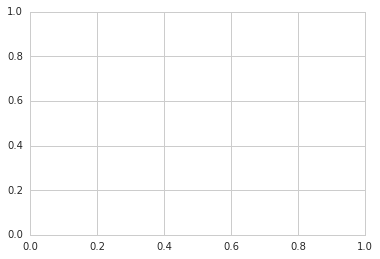

In [97]:
# plots the upper bound on the expected regret and the average expected regret from 1000 simulations. 

sns.set_style("whitegrid")
fig,ax = plt.subplots(1,figsize=(6,4))
ax.plot(T_range,r,color=sns.color_palette()[0],ls="dashed",label="upper bound")   
ax.plot(T_range,result.mean(axis=0)[2:],color=sns.color_palette()[0],label="simulated")
ax.set_ylabel("Pseudo-regret ${R}_T$")
ax.set_xlabel("Horizon $T$")
ax.legend(loc = "upper left")
plt.tight_layout()
fig.savefig('upper_bound_vs_actual_average_regret.pdf', format='pdf', dpi=1200)

In [78]:
# for a fixed T, plot the regret as function of delta, along with the upper bound
delta_range = np.linspace(0.001,.999,100)
T = 500



simulations = 1000

algorithm = AlphaUCB(4.0)

result = np.zeros((simulations,len(delta_range)))
for i, delta in enumerate(delta_range):
    enviroment = BasicBernoulliModel([.5-delta/2.0,.5+delta/2.0])
    for s in xrange(simulations):
        algorithm.run(T,enviroment)
        result[s,i] = algorithm.get_cumulative_regret()[-1]

In [117]:
def r1(delta,T):
    return np.true_divide(8*np.log(T),delta)+2
def r2(delta,T):
    return delta*T


In [124]:
a = r1(delta_range,T)
b = r2(delta_range,T)
boundary = np.flatnonzero(a < b)[0]
delta_1 = delta_range[0:boundary]
delta_2 = delta_range[boundary:]
a = a[boundary:]
b = b[0:boundary]


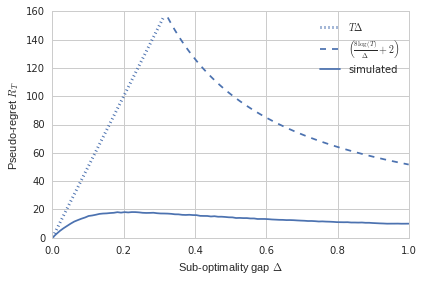

In [138]:
blue = sns.color_palette()[0]
r = regret_bound(delta_range,T)
fig,ax = plt.subplots(1,figsize=(6,4))
ax.plot(delta_1,b,linestyle=":",lw = 3,color=blue,label="$T\Delta$")
ax.plot(delta_2,a,linestyle="--",color=blue,label="$\\left(\\frac{8\\log(T)}{\Delta}+2 \\right)$")
ax.plot(delta_range,result.mean(axis=0),color=blue,label="simulated")
ax.legend(loc="upper right")
ax.set_xlabel("Sub-optimality gap $\Delta$")
ax.set_ylabel("Pseudo-regret $R_T$")

plt.tight_layout()
fig.savefig('ucb_regret_vs_delta.pdf', format='pdf', dpi=1200)


## Regret can be negative in adversarial settings

In [1]:
from causalpy.bandits import ThompsonSampling,TimeVaryingBernoulliModel,AlphaUCB
import numpy as np
import matplotlib.pyplot as plt
from causalpy.bandits import BasicBernoulliModel
import seaborn as sns
%matplotlib inline

T = 10000
model = TimeVaryingBernoulliModel(np.asarray([.9,.1]),np.asarray([.1,.8]),T)


expected_rewards = np.zeros((T,2))
for t in xrange(T):
    expected_rewards[t,:] = model.expected_rewards_t(t)



In [2]:
simulations = 1000
alg1 = ThompsonSampling()
alg2 = AlphaUCB(4)

arms = np.zeros((simulations,T))
rewards = np.zeros((simulations,T))

arms2 = np.zeros((simulations,T))
rewards2 = np.zeros((simulations,T))
for s in xrange(simulations):
    model = TimeVaryingBernoulliModel(np.asarray([.9,.1]),np.asarray([.1,.8]),T)
    alg1.run(T,model)
    arms[s,:] = alg1.arms
    rewards[s,:] = alg1.rewards
    
    model = TimeVaryingBernoulliModel(np.asarray([.9,.1]),np.asarray([.1,.8]),T)
    alg2.run(T,model)
    
    arms2[s,:] = alg2.arms
    rewards2[s,:] = alg2.rewards
    

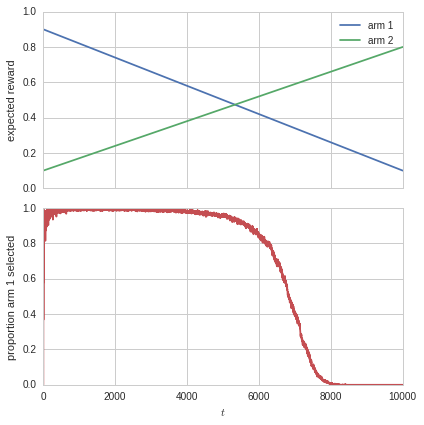

In [39]:
red =sns.color_palette()[2]
sns.set_style("whitegrid")
fig,ax = plt.subplots(2,1,figsize=(6,6),sharex=True,sharey=True)
ax[0].plot(range(T),expected_rewards[:,0],label = "arm 1")
ax[0].set_ylabel("expected reward")
ax[0].plot(range(T),expected_rewards[:,1],label = "arm 2")
ax[0].legend(loc="upper right")
ax[1].set_ylabel("proportion arm 1 selected")
ax[1].set_xlabel("$t$")
ax[1].plot(1-arms2.mean(axis=0),color=red)
plt.tight_layout()
fig.savefig('non-stationary-bandit-time.pdf', format='pdf', dpi=1200)

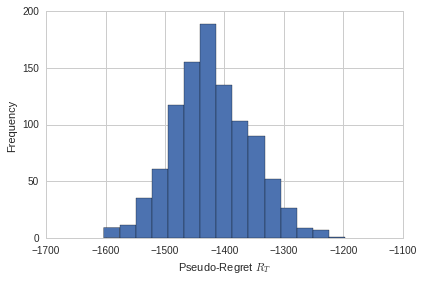

In [40]:

fig,ax = plt.subplots(1,figsize=(6,4))
ax.hist(.5*T-rewards2.sum(axis=1),bins=15,color=sns.color_palette()[0])
ax.set_xlabel("Pseudo-Regret $R_T$")
ax.set_ylabel("Frequency")
plt.tight_layout()
fig.savefig('non-stationary-bandit-regret.pdf', format='pdf', dpi=1200)

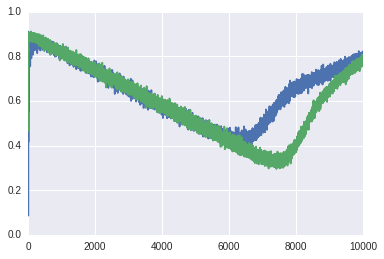

In [7]:
plt.plot(rewards2.mean(axis=0))
plt.plot(rewards.mean(axis=0))

(10000, 2)
(1000, 10000)


(array([  23.,    8.,    8.,   10.,    7.,   10.,   20.,   18.,   25.,   30.,   42.,   47.,   56.,   83.,   97.,  135.,  153.,  127.,   78.,   23.]),
 array([ 4996.32455,  5065.81236,  5135.30017,  5204.78798,  5274.27579,  5343.7636 ,  5413.25141,  5482.73922,  5552.22703,  5621.71484,  5691.20265,  5760.69046,  5830.17827,  5899.66608,
         5969.15389,  6038.6417 ,  6108.12951,  6177.61732,  6247.10513,  6316.59294,  6386.08075]),
 <a list of 20 Patch objects>)

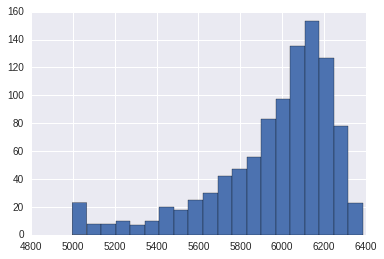

In [110]:
print rewards.shape
print arms.shape
v = rewards[np.arange(T),arms]
plt.hist(v.sum(axis=1),bins = 20)

In [61]:
np.take(rewards[:,0],a)


array([ 0.9    ,  0.9    ,  0.89992, ...,  0.89992,  0.89992,  0.89992])

In [63]:
rewards[:,0]

array([ 0.9    ,  0.89992,  0.89984, ...,  0.10024,  0.10016,  0.10008])

In [72]:
vals = np.arange(6).reshape((3,2)).astype(float)
print vals
print vals[:,0]

[[ 0.  1.]
 [ 2.  3.]
 [ 4.  5.]]
[ 0.  2.  4.]


In [80]:
indx = np.asarray([np.arange(3),np.asarray([0,0,1])]).T
print indx
np.take(vals,indx)

[[0 0]
 [1 0]
 [2 1]]


array([[ 0.,  0.],
       [ 1.,  0.],
       [ 2.,  1.]])

In [98]:
a = np.arange(6).reshape((3,2))
indx = np.asarray([1,0,0])

print a
print "goal", [a[0,1],a[1,0],a[2,0]] # goal

a[np.arange(3),indx]

[[0 1]
 [2 3]
 [4 5]]
goal [1, 2, 4]


array([1, 2, 4])

In [96]:
input_array = np.array( [ [3,14], [12, 5], [75, 50] ] )
select_id = [0, 1, 1]
print input_array


output_array = input_array[  range( input_array.shape[0] ), select_id ]
print output_array


[[ 3 14]
 [12  5]
 [75 50]]
[ 3  5 50]


In [87]:
print a
row_idx = np.array([0, 1, 3])
col_idx = np.array([0, 2])
a[row_idx.T, col_idx]

IndexError: too many indices for array

In [86]:
row_idx

array([0, 1, 3])